In [21]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
info = pd.read_csv(
    "node_information.csv", 
    header= None, 
    names=["Id", "year", "title", "authors", "journal", "abstract"],
    sep=","
)

In [26]:
train = pd.read_csv("training_set.txt", sep=" ", header=None)
test = pd.read_csv("testing_set.txt", sep=" ", header=None)

In [32]:
len(pd.unique(train[0])), len(pd.unique(train[1])), train.shape[0]

(27770, 27770, 615512)

In [33]:
len(pd.unique(test[0])), len(pd.unique(test[1])), test.shape[0]

(17709, 16346, 32648)

In [16]:
len(np.unique(info["journal"]))

285

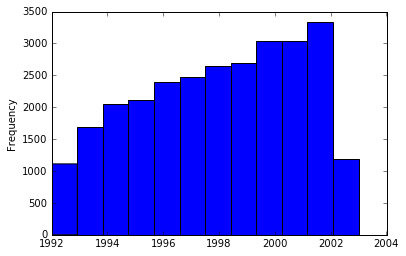

In [11]:
info["year"].plot(kind="hist", bins=len(np.unique(info["year"])))

In [36]:
info.head()

,Id,year,title,authors,journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


7472

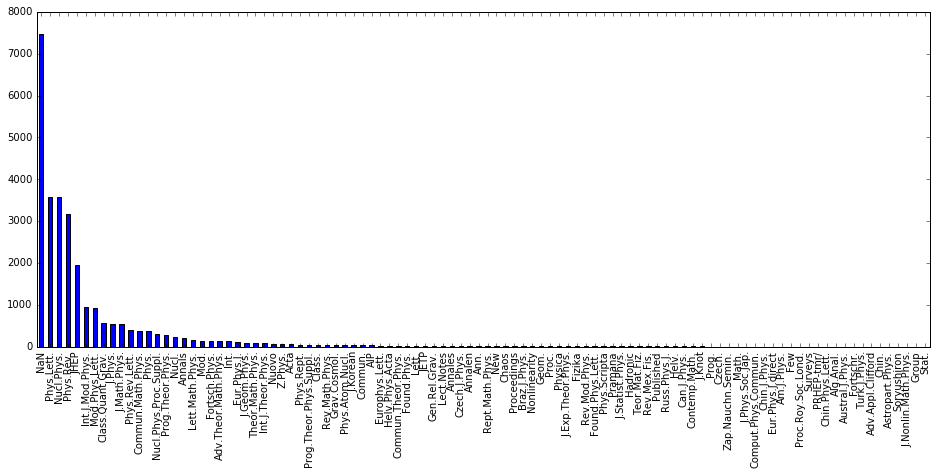

In [175]:
plt.figure(figsize=(16,6))
journals=pd.get_dummies(info["journal"]).sum()
journals["NaN"] = info["journal"].isnull().sum()
journals.sort_values(ascending=False)[:100].plot(kind="bar")

In [177]:
np.nan == np.nan

False

In [37]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]



In [122]:
import networkx as nx
###############################
# beating the random baseline #
###############################

# the following script gets an F1 score of approximately 0.66

# data loading and preprocessing 

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes
"""
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)
"""
IDs = [element[0] for element in node_info]

# randomly select 5% of training set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = train.loc[to_keep]

# in this baseline we will use three basic features:

# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []



counter = 0
def make_graph(training_set_reduced):
    G = nx.DiGraph()
    for i in training_set_reduced.index:
        source = training_set_reduced.loc[i,0]
        target = training_set_reduced.loc[i,1]
        G.add_node(source)
        G.add_node(target)
        if training_set_reduced.loc[i,2] ==1:
            G.add_edge(source,target)
    return G

G = make_graph(training_set_reduced)   

In [143]:
def compute_betweeness_array(array_from_to, graph):
    centrality = nx.degree_centrality(graph)
    def fill_centrality(from_to):
        return np.array([centrality[from_to[0]], centrality[from_to[1]]])
    array=np.apply_along_axis(fill_centrality, 1, array_from_to)
    return np.apply_along_axis(lambda x: x[1]-x[0], 1, array)

In [146]:
compute_betweeness_array(training_set_reduced, G)

array([  4.38577255e-05,   1.75430902e-04,   4.38577255e-05, ...,
         5.26292706e-04,  -1.75430902e-04,   4.38577255e-05])

In [153]:
def compute_diff_inlinks(array_from_to, graph):
    in_degrees=graph.in_degree()
    def fill_diff_inlinks(from_to):
        return np.array([in_degrees[from_to[0]], in_degrees[from_to[1]]])
    array=np.apply_along_axis(fill_diff_inlinks, 1, array_from_to)
    return np.apply_along_axis(lambda x: x[1]-x[0], 1, array)

In [154]:
compute_diff_inlinks(training_set_reduced, G)

array([ 0,  4,  5, ..., 15, -1,  0])

In [157]:
def compute_to_inlinks(array_from_to, graph):
    in_degrees=graph.in_degree()
    def fill_to_inlinks(from_to):
        return in_degrees[from_to[1]]
    return np.apply_along_axis(fill_to_inlinks, 1, array_from_to)

In [158]:
compute_to_inlinks(training_set_reduced, G)

array([ 0,  5,  5, ..., 15,  0,  0])

In [192]:
def compute_same_journals(array_from_to, info):
    def fill_same_journals(from_to):
        if info.loc[info["Id"]==from_to[0], "journal"].values == info.loc[info["Id"]==from_to[1], "journal"].values:
            return 1
        else:
            return 0
    return np.apply_along_axis(fill_same_journals, 1, array_from_to)

In [194]:
same_jour=compute_same_journals(training_set_reduced, info)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  app.launch_new_instance()


In [195]:
same_jour.sum()

4985

In [185]:
info.loc[info["Id"]==training_set_reduced[0][0], "journal"] == info.loc[info["Id"]==training_set_reduced[0][0], "journal"].values

23274    True
Name: journal, dtype: bool

In [190]:
if info.loc[info["Id"]==training_set_reduced[0][0], "journal"].values == info.loc[info["Id"]==training_set_reduced[0][1], "journal"].values:
    print "hi"